In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf,lit
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import pickle
import pandas as pd
import numpy as np
from transform import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName('Spark-201-project') \
                    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Read train and test data

In [41]:
%%time
train_df = spark.read.csv('data/fraudTrain.csv', header=True)
test_df = spark.read.csv('data/fraudTest.csv', header=True)

CPU times: user 2.09 ms, sys: 3.49 ms, total: 5.57 ms
Wall time: 326 ms


In [43]:
train_df.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

### Transform data using transformation pipeline

In [5]:
get_age_fn = get_age_from_dob(input_col="dob", output_col="age")
get_time_fn = get_time(input_col="trans_date_trans_time", output_col="time")
amt_int_fn = cast_int(input_col="amt",output_col="amt")
city_pop_int_fn = cast_int(input_col="city_pop",output_col="city_pop")
is_fraud_int_fn = cast_int(input_col="is_fraud",output_col="is_fraud")

transformer_pipeline = Pipeline(stages=[get_age_fn,get_time_fn,amt_int_fn,city_pop_int_fn,is_fraud_int_fn])

In [6]:
%%time
transformer_model = transformer_pipeline.fit(train_df)
train_df = transformer_model.transform(train_df)
test_df = transformer_model.transform(test_df)

CPU times: user 22.5 ms, sys: 34.6 ms, total: 57.1 ms
Wall time: 275 ms


In [7]:
train_data = train_df.select(col("time"), col("amt"), col("city_pop"), col("age"), col("is_fraud"))
test_data = test_df.select(col("time"), col("amt"), col("city_pop"), col("age"), col("is_fraud"))

In [8]:
train_data.show()
train_data.printSchema()

+----+---+--------+---+--------+
|time|amt|city_pop|age|is_fraud|
+----+---+--------+---+--------+
|   0|  4|    3495| 33|       0|
|   0|107|     149| 43|       0|
|   0|220|    4154| 59|       0|
|   0| 45|    1939| 54|       0|
|   0| 41|      99| 35|       0|
|   0| 94|    2158| 60|       0|
|   0| 44|    2691| 28|       0|
|   0| 71|    6018| 74|       0|
|   0|  4|    1472| 80|       0|
|   0|198|  151785| 47|       0|
|   0| 24|    7297| 31|       0|
|   0|  7|    1925| 55|       0|
|   0| 71|  341043| 32|       0|
|   0| 96|     589| 76|       0|
|   0|  7|     899| 54|       0|
|   0|  3|    4664| 56|       0|
|   0|327|    1078| 69|       0|
|   0|341|    4081| 83|       0|
|   0| 63|    2518| 75|       0|
|   0| 44|  124967| 41|       0|
+----+---+--------+---+--------+
only showing top 20 rows

root
 |-- time: integer (nullable = true)
 |-- amt: integer (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- is_fraud: integer (nul

## PySpark Model

### Create features for training model

In [9]:
feature_columns = ['time', 'amt', 'city_pop', 'age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

### Train

In [10]:
rf = RandomForestClassifier(maxDepth=3,numTrees=10,labelCol="is_fraud",featuresCol='features', seed=6)

In [11]:
%%time
rf_model_spark = rf.fit(train_data)

CPU times: user 28 ms, sys: 44.7 ms, total: 72.7 ms
Wall time: 12.1 s


### Predictions

In [12]:
%%time
predictions = rf_model_spark.transform(test_data)

CPU times: user 5.89 ms, sys: 10 ms, total: 15.9 ms
Wall time: 58.7 ms


In [13]:
%%time
correct = predictions.where(col('prediction')==col('is_fraud')).count()
total = predictions.count()

print("Accuracy: ", correct/total)

Accuracy:  0.9961401355721147
CPU times: user 11 ms, sys: 28.6 ms, total: 39.5 ms
Wall time: 1.63 s


## Load and broadcast a previously trained RF model

In [14]:
model_data = sc.binaryFiles("rf_model.pkl").collect()
rf_model = pickle.loads(model_data[0][1])
rf_model_bc = sc.broadcast(rf_model)

def predict_fn(*cols):
    cols = np.array(cols).reshape((1,-1))
    prediction = rf_model_bc.value.predict_proba((cols))
    return int( float(prediction[0,1]) > 0.5 )

predict = udf(predict_fn, IntegerType())

### Predictions

In [15]:
%%time
df = test_data.withColumn("score", predict(*feature_columns))
df.show()

+----+---+--------+---+--------+--------------------+-----+
|time|amt|city_pop|age|is_fraud|            features|score|
+----+---+--------+---+--------+--------------------+-----+
|  12|  2|  333497| 53|       0|[12.0,2.0,333497....|    0|
|  12| 29|     302| 31|       0|[12.0,29.0,302.0,...|    0|
|  12| 41|   34496| 51|       0|[12.0,41.0,34496....|    0|
|  12| 60|   54767| 34|       0|[12.0,60.0,54767....|    0|
|  12|  3|    1126| 66|       0|[12.0,3.0,1126.0,...|    0|
|  12| 19|     520| 30|       0|[12.0,19.0,520.0,...|    0|
|  12|133|    1139| 70|       0|[12.0,133.0,1139....|    0|
|  12| 10|     343| 49|       0|[12.0,10.0,343.0,...|    0|
|  12|  4|    3688| 48|       0|[12.0,4.0,3688.0,...|    0|
|  12| 66|     263| 65|       0|[12.0,66.0,263.0,...|    0|
|  12|  7|     564| 25|       0|[12.0,7.0,564.0,2...|    0|
|  12| 42|    1645| 45|       0|[12.0,42.0,1645.0...|    0|
|  12|  2|   26551| 44|       0|[12.0,2.0,26551.0...|    0|
|  12|  7|    2258| 84|       0|[12.0,7.

In [16]:
%%time
correct = df.filter(col('score')==col('is_fraud')).count()
total = df.count()

print(correct/total)

0.9970524671641603
CPU times: user 13.2 ms, sys: 13.5 ms, total: 26.7 ms
Wall time: 1min 24s


## Caching


In [17]:
train_data.cache()
test_data.cache()

DataFrame[time: int, amt: int, city_pop: int, age: int, is_fraud: int, features: vector]

### Re-train Pyspark model

In [18]:
%%time
rf_model_spark = rf.fit(train_data)

CPU times: user 26.9 ms, sys: 51 ms, total: 77.8 ms
Wall time: 7.57 s


### Predictions

In [19]:
%%time
predictions = rf_model_spark.transform(test_data)

CPU times: user 9.6 ms, sys: 15.6 ms, total: 25.2 ms
Wall time: 68.1 ms


In [20]:
%%time
correct = predictions.where(col('prediction')==col('is_fraud')).count()
total = predictions.count()

print("Accuracy: ", correct/total)

Accuracy:  0.9961401355721147
CPU times: user 9.78 ms, sys: 19.9 ms, total: 29.7 ms
Wall time: 2.13 s


### Predictions for broadcasted model

In [21]:
%%time
df = test_data.withColumn("score", predict(*feature_columns))
df.show()

+----+---+--------+---+--------+--------------------+-----+
|time|amt|city_pop|age|is_fraud|            features|score|
+----+---+--------+---+--------+--------------------+-----+
|  12|  2|  333497| 53|       0|[12.0,2.0,333497....|    0|
|  12| 29|     302| 31|       0|[12.0,29.0,302.0,...|    0|
|  12| 41|   34496| 51|       0|[12.0,41.0,34496....|    0|
|  12| 60|   54767| 34|       0|[12.0,60.0,54767....|    0|
|  12|  3|    1126| 66|       0|[12.0,3.0,1126.0,...|    0|
|  12| 19|     520| 30|       0|[12.0,19.0,520.0,...|    0|
|  12|133|    1139| 70|       0|[12.0,133.0,1139....|    0|
|  12| 10|     343| 49|       0|[12.0,10.0,343.0,...|    0|
|  12|  4|    3688| 48|       0|[12.0,4.0,3688.0,...|    0|
|  12| 66|     263| 65|       0|[12.0,66.0,263.0,...|    0|
|  12|  7|     564| 25|       0|[12.0,7.0,564.0,2...|    0|
|  12| 42|    1645| 45|       0|[12.0,42.0,1645.0...|    0|
|  12|  2|   26551| 44|       0|[12.0,2.0,26551.0...|    0|
|  12|  7|    2258| 84|       0|[12.0,7.

In [22]:
%%time
correct = df.filter(col('score')==col('is_fraud')).count()
total = df.count()

print(correct/total)

0.9970524671641603
CPU times: user 16.9 ms, sys: 26.4 ms, total: 43.3 ms
Wall time: 1min 24s


### Caching the previously trained model and making predictions on cached data

In [32]:
model_pkl = sc.binaryFiles("rf_model.pkl")
model_pkl.cache()
model_data = model_pkl.collect()
rf_model = pickle.loads(model_data[0][1])
rf_model_bc = sc.broadcast(rf_model)

def predict_fn(*cols):
    cols = np.array(cols).reshape((1,-1))
    prediction = rf_model_bc.value.predict_proba((cols))
    return int( float(prediction[0,1]) > 0.5 )

predict = udf(predict_fn, IntegerType())

In [33]:
%%time
df = test_data.withColumn("score", predict(*feature_columns))
df.show()

+----+---+--------+---+--------+--------------------+-----+
|time|amt|city_pop|age|is_fraud|            features|score|
+----+---+--------+---+--------+--------------------+-----+
|  12|  2|  333497| 53|       0|[12.0,2.0,333497....|    0|
|  12| 29|     302| 31|       0|[12.0,29.0,302.0,...|    0|
|  12| 41|   34496| 51|       0|[12.0,41.0,34496....|    0|
|  12| 60|   54767| 34|       0|[12.0,60.0,54767....|    0|
|  12|  3|    1126| 66|       0|[12.0,3.0,1126.0,...|    0|
|  12| 19|     520| 30|       0|[12.0,19.0,520.0,...|    0|
|  12|133|    1139| 70|       0|[12.0,133.0,1139....|    0|
|  12| 10|     343| 49|       0|[12.0,10.0,343.0,...|    0|
|  12|  4|    3688| 48|       0|[12.0,4.0,3688.0,...|    0|
|  12| 66|     263| 65|       0|[12.0,66.0,263.0,...|    0|
|  12|  7|     564| 25|       0|[12.0,7.0,564.0,2...|    0|
|  12| 42|    1645| 45|       0|[12.0,42.0,1645.0...|    0|
|  12|  2|   26551| 44|       0|[12.0,2.0,26551.0...|    0|
|  12|  7|    2258| 84|       0|[12.0,7.

In [34]:
%%time
correct = df.filter(col('score')==col('is_fraud')).count()
total = df.count()

print(correct/total)

0.9970524671641603
CPU times: user 12.6 ms, sys: 15.6 ms, total: 28.1 ms
Wall time: 1min 25s


In [35]:
# train_data.unpersist()
# test_data.unpersist()

## Evaluation of pyspark model

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from itertools import chain

In [37]:
predictions = rf_model_spark.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))


preds_and_labels = predictions.select(['prediction','is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

Accuracy = 0.9119739259417061
Test Error = 0.08802607405829388


[[553574.      0.]
 [  2145.      0.]]


## Weighted training

In [38]:
y_collect = train_data.select("is_fraud").groupBy("is_fraud").count().collect()
unique_y = [x["is_fraud"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
train_data = train_data.withColumn("weight", mapping_expr.getItem(F.col("is_fraud")))

{1: 86.37589928057554, 0: 0.5029111776656126}


In [39]:
%%time
rf_weight = RandomForestClassifier(maxDepth=3,numTrees=10,labelCol="is_fraud",featuresCol='features',weightCol="weight", seed=6)
rf_model_weight = rf_weight.fit(train_data)

CPU times: user 16.7 ms, sys: 35.1 ms, total: 51.8 ms
Wall time: 1.82 s


In [40]:
predictions = rf_model_weight.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))


preds_and_labels = predictions.select(['prediction','is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

Accuracy = 0.9424058617591913
Test Error = 0.05759413824080872


[[5.19583e+05 3.39910e+04]
 [3.60000e+02 1.78500e+03]]


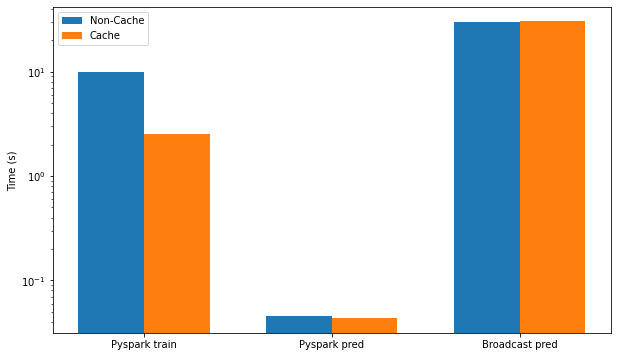

In [53]:
import matplotlib.pyplot as plt
N=3
ind = np.arange(N) 
width = 0.35 

non_cache = [9.88, 0.0452, 29.8]
cache = [2.51, 0.0436, 30.3]

plt.figure(figsize=(10,6))
plt.bar(ind, non_cache, width, label='Non-Cache')
plt.bar(ind + width, cache, width,
    label='Cache')
plt.yscale("log")
plt.xticks(ind + width / 2, ('Pyspark train','Pyspark pred','Broadcast pred'))
plt.ylabel("Time (s)")
plt.legend(loc='best')
plt.show()